In [1]:
import csv
import numpy as np
import pandas as pd
from math import factorial

import datetime
from datetime import date

import time

import scipy
import os, os.path
from os import listdir
from os.path import isfile, join

import re
# from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
import NASA_plot_core as npc

In [2]:
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/" + \
           "10_intersect_Grant_Irr_2008_2018_2cols/"

L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_102008-01-01_2012-05-05.csv")
L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_10_2008-01-01_2021-09-23.csv")
L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_int_Grant_Irr_2008_2018_2cols_10_2008-01-01_2021-10-14.csv")

In [3]:
# data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/sixth_investig_intersected/"

# L5 = pd.read_csv(data_dir + "L5_T1C2L2_Scaled_intGrant_2008-01-01_2012-05-05.csv")
# L7 = pd.read_csv(data_dir + "L7_T1C2L2_Scaled_intGrant_2008-01-01_2021-09-23.csv")
# L8 = pd.read_csv(data_dir + "L8_T1C2L2_Scaled_intGrant_2008-01-01_2021-10-14.csv")

In [5]:
indeks = "EVI"

if indeks == "NDVI":
    NoVI = "EVI"
else:
    NoVI = "NDVI"
    
IDcolName = "ID"

In [6]:
L5.drop([NoVI], axis=1, inplace=True)
L5 = L5[L5[indeks].notna()]

L7.drop([NoVI], axis=1, inplace=True)
L7 = L7[L7[indeks].notna()]

L8.drop([NoVI], axis=1, inplace=True)
L8 = L8[L8[indeks].notna()]
L8.head(2)

,ID,EVI,system_start_time
28100,i27636,0.241194,1.364238e+12
28101,i47765,0.167561,1.364238e+12


In [7]:
IDs = np.sort(L5[IDcolName].unique())
L578 = pd.concat([L5, L7, L8])

,ID,EVI,system_start_time
42144,i57244,0.222482,1.204396e+12
42145,i62339,0.074632,1.204396e+12


In [8]:
del(L5, L7, L8)
L578 = nc.add_human_start_time_by_system_start_time(L578)

In [9]:
# i27373
a_field = L578.loc[L578.ID == "i17302", ].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
a_field.reset_index(drop=True, inplace=True)

### pre-processing

In [10]:
a_field = nc.initial_clean(df = a_field, column_to_be_cleaned = indeks)
a_field.drop(["system_start_time"], axis=1, inplace=True)

,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


In [11]:
print (a_field[indeks].min())
print (a_field[indeks].max())

-1.5
1.5


# Remove/Interpolate Outliers

In [12]:
noOutlier = nc.interpolate_outliers_EVI_NDVI(outlier_input=a_field, given_col=indeks)
print (noOutlier.shape)
noOutlier.head(2)

(685, 3)


,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


In [13]:
print (noOutlier[indeks].min())
print (noOutlier[indeks].max())
noOutlier.equals(a_field)

-0.2236942112573014
0.9547879015211858


False

# Correct Big Jumps

In [14]:
NoJump_v1 = nc.correct_big_jumps_1DaySeries(dataTMS_jumpie = noOutlier, give_col = indeks, maxjump_perDay = 0.018)

In [17]:
NoJump_v2 = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie = noOutlier, 
                                            give_col = indeks, 
                                            maxjump_perDay = 0.018)

,ID,EVI,human_system_start_time
0,i17302,0.147630,2008-01-05
1,i17302,-0.067435,2008-01-21


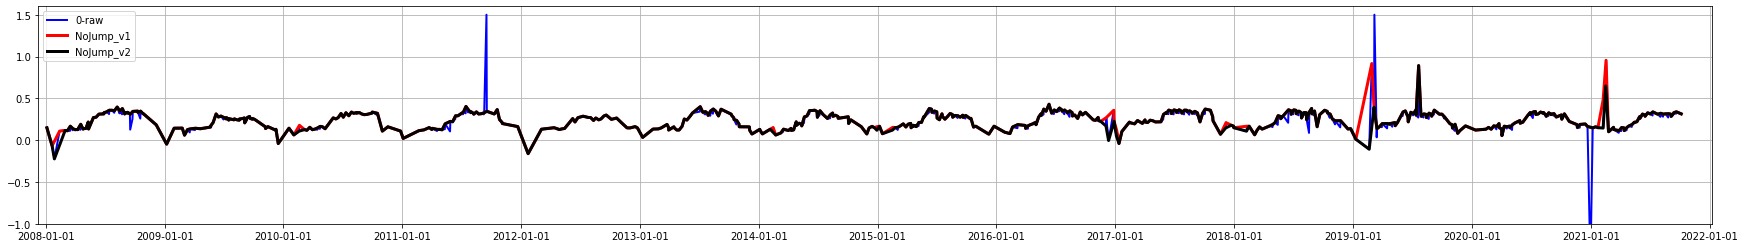

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], 
        a_field['EVI'], 
        '-', linewidth=2, color='b', label = "0-raw")

ax.plot(NoJump_v1['human_system_start_time'], 
        NoJump_v1['EVI'], 
        '-', linewidth=3, color='r', label = "NoJump_v1")

ax.plot(NoJump_v2['human_system_start_time'], 
        NoJump_v2['EVI'], 
        '-', linewidth=3, color='k', label = "NoJump_v2")

xx = datetime.date(2019, 2, 28)
# plt.axvline(x=xx, color="red", label=xx)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.6)
ax.set_xlim([datetime.date(2007, 12, 10), datetime.date(2022, 1, 10)])
# ax.set_xlim([datetime.date(2019, 1, 10), datetime.date(2020, 1, 1)])

plot_dir = "/Users/hn/Desktop/"
# file_name = plot_dir + # "i17302.pdf"
# plt.savefig(fname = file_name, dpi=100, bbox_inches='tight', transparent=False)

# Regularize

In [35]:
regular_window_size = 10
regular = nc.regularize_a_field(a_df = NoJump_v2, \
                                V_idks = indeks, \
                                interval_size = regular_window_size,\
                                start_year=2008, \
                                end_year=2021)

In [36]:
regular = nc.fill_theGap_linearLine(a_regularized_TS=regular, V_idx=indeks)

In [18]:
# all_years = np.arange(start_year, end_year+1)
# leapyear_count = np.sum([is_leap_year(item) for item in all_years])
# total_no_days = (leapyear_count*366) + ((end_year - start_year + 1 - leapyear_count)*365)
# total_no_points = total_no_days//interval_size
# missing_count = total_no_points - regular_df.shape[0]
# missing_from_beginning = (min(regular_df.human_system_start_time) - \
#                           pd.to_datetime(datetime.datetime(start_year, 1, 1, 0, 0))).days // interval_size

# missing_from_end = missing_count - missing_from_beginning
# print (missing_count)
# print (missing_from_beginning)
# print (missing_from_end)

# missing_begin_df = pd.DataFrame(data = None, 
#                                 index = np.arange(missing_from_beginning), 
#                                 columns = regular_cols)
# missing_begin_df.ID = regular_df.ID.unique()[0]
# mm=min(regular_df.human_system_start_time)
# missing_begin_df[V_idks] = np.array(regular_df[regular_df.human_system_start_time == mm][indeks])[0]
# if "dataset" in regular_cols:
#     missing_begin_df.dataset = regular_df.dataset.unique()[0]

# A = pd.date_range(pd.Timestamp(start_year, 1, 1),
#                    min(regular_df.human_system_start_time),
#                    freq=str(interval_size)+'D')
# missing_begin_df.human_system_start_time = A[:-1]


# missing_end_df = pd.DataFrame(data = None, 
#                               index = np.arange(missing_from_end), 
#                               columns = regular_cols)
# missing_end_df.ID = regular_df.ID.unique()[0]
# mm=max(regular_df.human_system_start_time)
# missing_end_df[V_idks] = np.array(regular_df[regular_df.human_system_start_time == mm][indeks])[0]

# if "dataset" in regular_cols:
#     missing_end_df.dataset = regular_df.dataset.unique()[0]
# regular_df[regular_df.human_system_start_time == mm][indeks]


# np.timedelta64(time_diff, 's').astype(int)

# time_diff.astype(pd.Timedelta)

# time_diff.astype(pd.Timedelta)

# vvv = int(x2) - int(x1) 

# vvv == time_diff.astype(pd.Timedelta)

# print (time_diff)
# np.timedelta64(time_diff, 's').astype(int)

# pd.to_datetime(int(time_vec[left_pointer]))


# SG

In [37]:
SG = scipy.signal.savgol_filter(regular[indeks].values, window_length=7, polyorder=3)
SG[SG > 1 ] = 1 # SG might violate the boundaries. clip them:
SG[SG < -1 ] = -1

In [38]:
SG_df = regular.copy()
SG_df[indeks] = SG
SG_df.head(2)


,ID,human_system_start_time,EVI
0,i17302,2008-01-05,0.157563
1,i17302,2008-01-15,-0.107446


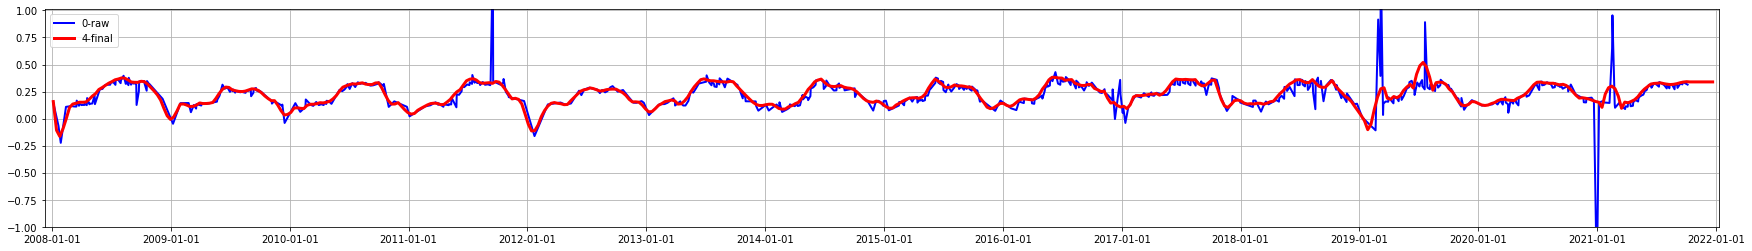

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(30, 4),
                        sharex='col', sharey='row',
                        # sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], 
        a_field['EVI'], 
        '-', linewidth=2, color='b', label = "0-raw")

# ax.scatter(a_field['human_system_start_time'], 
#            a_field['EVI'], 
#            marker='+', linewidth=20, color='b', label = "0-raw")

# ax.plot(noOutlier['human_system_start_time'], 
#         noOutlier['EVI'], 
#         '-', linewidth=2, color='c', label = "1-noOutlier")

# ax.scatter(noOutlier['human_system_start_time'], 
#            noOutlier['EVI'], 
#            marker='+', linewidth=10, color='y', label = "1-noOutlier")

# ax.plot(NoJump['human_system_start_time'], 
#         NoJump['EVI'], 
#         '-', linewidth=5, color='k', label = "2-NoJump")

# ax.scatter(x=NoJump['human_system_start_time'], 
#            y=NoJump['EVI'], 
#            marker='*', linewidth=10, color='k', label = "2-NoJump")

# ax.plot(regular['human_system_start_time'], 
#         regular['EVI'], 
#         '-', linewidth=5, color='g', label = "3-regular")

ax.plot(regular['human_system_start_time'], 
        SG, 
        '-', linewidth=3, color='r', label = "4-final")

xx = datetime.date(2019, 2, 28)
# plt.axvline(x=xx, color="red", label=xx)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.01)
ax.set_xlim([datetime.date(2007, 12, 10), datetime.date(2022, 1, 10)])
# ax.set_xlim([datetime.date(2018, 12, 10), datetime.date(2020, 1, 10)])

plot_dir = "/Users/hn/Desktop/"
file_name = plot_dir + "i17302.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# file_name = plot_dir + "i17302.png"
# plt.savefig(fname = file_name, dpi=100, bbox_inches='tight', transparent=False)

(13857.0, 19002.0)

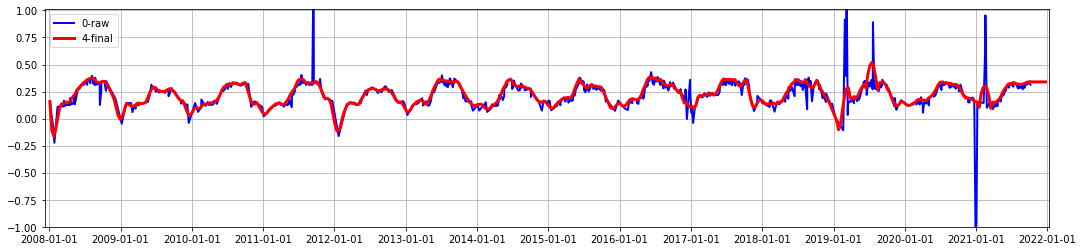

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4),
                       sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], 
        a_field['EVI'], 
        '-', linewidth=2, color='b', label = "0-raw")

# ax.scatter(a_field['human_system_start_time'], 
#            a_field['EVI'], linewidth=0.1, color='b', label = "0-raw")

ax.plot(regular['human_system_start_time'], 
        SG, 
        '-', linewidth=3, color='r', label = "4-final")

xx = datetime.date(2019, 2, 28)

ax.xaxis.set_major_locator(mdates.YearLocator(1)) # every year.
ax.legend(loc="upper left");
ax.set_ylim(-1, 1.01)
ax.set_xlim([datetime.date(2007, 12, 10), datetime.date(2022, 1, 10)])
# ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 1, 1)])

# SOS Detection

In [40]:
raw_df = L578.copy()

In [42]:
yr=2008
indeks = "EVI"

data_dird = "/Users/hn/Documents/01_research_data/NASA/data_deBug/"
a_df = pd.read_csv( data_dird + "04_SG_int_Grant_Irr_2008_2018_EVI_100randomfields.csv", low_memory=False)
a_df['human_system_start_time'] = pd.to_datetime(a_df['human_system_start_time'])
a_df.head(2)

,ID,human_system_start_time,EVI
0,i17302,2008-01-05,0.135153
1,i17302,2008-01-15,0.024221


In [43]:
ID = a_df.ID.unique()[4]

In [44]:
curr_SG = a_df[a_df['ID'] == ID].copy()
curr_SG.sort_values(by=['human_system_start_time'], inplace=True)
curr_SG.reset_index(drop=True, inplace=True)

curr_raw = raw_df[raw_df['ID'] == ID].copy()
curr_raw.sort_values(by=['human_system_start_time'], inplace=True)
curr_raw.reset_index(drop=True, inplace=True)

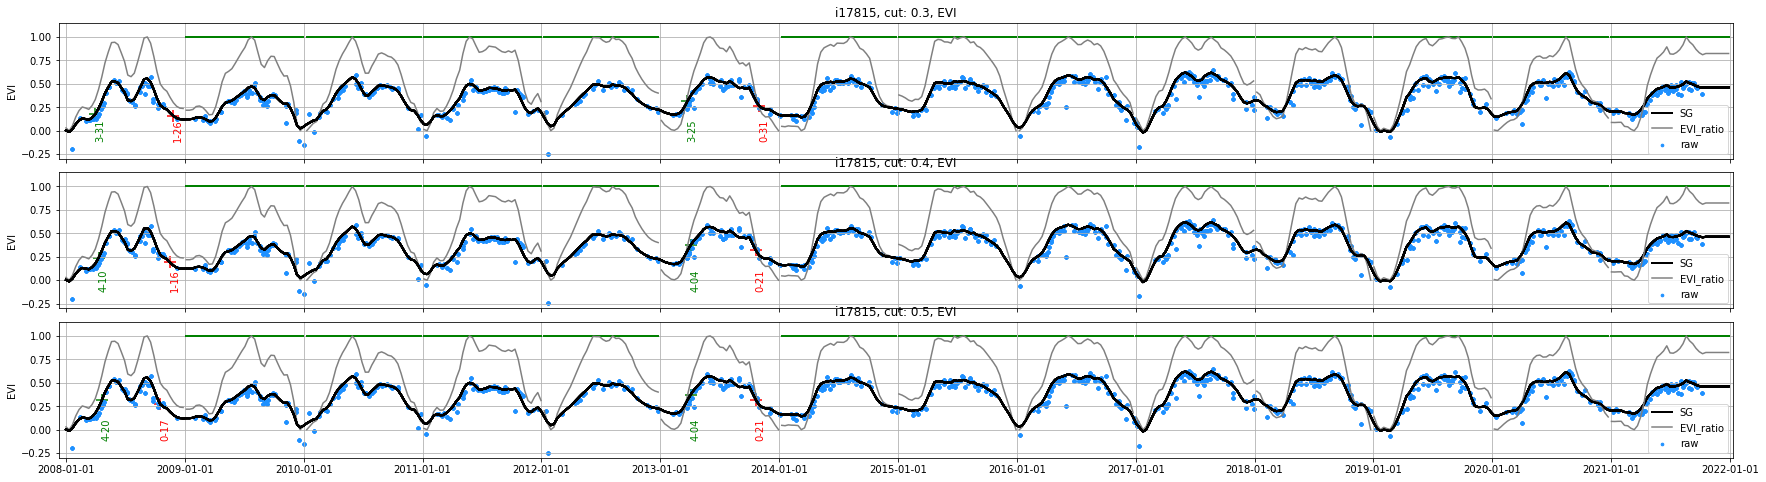

In [47]:
fig, axs = plt.subplots(3, 1, figsize=(30, 8),
                            sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0.1, 'wspace': .1});
(ax1, ax2, ax3) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True);

npc.SG_clean_SOS_orchardinPlot(raw_dt = curr_raw,
                SG_dt = curr_SG,
                idx = indeks,
                ax = ax1,
                onset_cut = 0.3, 
                offset_cut = 0.3);

npc.SG_clean_SOS_orchardinPlot(raw_dt = curr_raw,
             SG_dt = curr_SG,
             idx = indeks,
             ax = ax2,
             onset_cut = 0.4, 
             offset_cut = 0.4);

npc.SG_clean_SOS_orchardinPlot(raw_dt = curr_raw,
                 SG_dt = curr_SG,
                idx = indeks,
                ax = ax3,
                onset_cut = 0.5, 
                offset_cut = 0.5);


plot_dir = "/Users/hn/Desktop/"
file_name = plot_dir + "i17302_SOS.pdf"
plt.savefig(fname = file_name, dpi=200, bbox_inches='tight', transparent=False)


In [16]:
# pd.to_datetime(datetime.datetime(yr, 5, 1))
# pd.to_datetime(datetime.datetime(yr, 11, 1))

# Find SOS and EOS

In [131]:
raw_dt = curr_raw
SG_dt = curr_SG

In [74]:
try:
  print(x)
except:
  print("An exception occurred")

An exception occurred


In [67]:
t = 1203791277577

t = t / 1000

time.strftime('%Y-%m-%d', time.localtime(t))

'2008-02-23'

len(IDs) is 19!


In [77]:
"Hey Come"

'Hey_Come'

In [79]:
366*3 // 10

109